### The tf.data API

In [3]:
import tensorflow as tf
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [4]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


> NOTE
The tf.data API is a streaming API: you can very efficiently iterate through a dataset’s
items, but the API is not designed for indexing or slicing.



In [5]:
"""When slicing a
tuple, a dictionary, or a nested structure, the dataset will only slice the
tensors it contains, while preserving the tuple/dictionary structure"""

X_nested = {"a":([1,2,3],[4,5,6]),"b":[7,8,9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### Chain Transformation

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


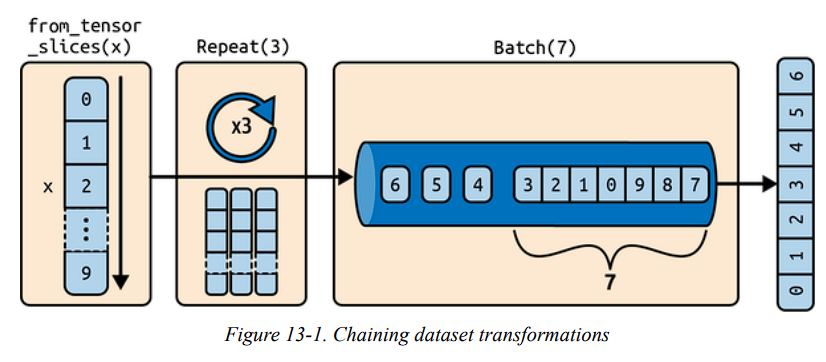

 call
batch() with drop_remainder=True if you want it to drop this final batch,
such that all batches have the exact same size.

>WARNING
The dataset methods do not modify datasets—they create new ones. So make sure to
keep a reference to these new datasets (e.g., with dataset = ...), or else nothing will
happen.

In [7]:
"""You can also transform the items by calling the map() method. For
example, this creates a new dataset with all batches multiplied by two:"""

dataset = dataset.map(lambda x: x*2) # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [8]:
"""It is also possible to simply filter the dataset using the filter() method.
For example, this code creates a dataset that only contains the batchs whose
sum is greater than 50:
"""

dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [9]:
"""You will often want to look at just a few items from a dataset. You can use
the take() method for that:"""
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


#### Shuffling the data

It will create a new dataset that will start by filling up a
buffer with the first items of the source dataset. Then, whenever it is asked
for an item, it will pull one out randomly from the buffer and replace it with
a fresh one from the source dataset, until it has iterated entirely through the
source dataset. At this point it will continue to pull out items randomly from
the buffer until it is empty

must specify the buffer size, and it is
important to make it large enough, or else shuffling will not be very
effective

In [10]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4,seed=42).batch(7)
for i in dataset:
    print(i)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


> TIP
If you call repeat() on a shuffled dataset, by default it will generate a new order at
every iteration. This is generally a good idea, but if you prefer to reuse the same order at
each iteration (e.g., for tests or debugging), you can set reshuffle_each_
iteration=False when calling shuffle().

For large dataset that doesn't fit in memory:

To avoid biased model you can pick multiple files randomly and read them
simultaneously, interleaving their records. Then on top of that you can add a
shuffling buffer using the shuffle() method

#### Interleaving Lines from Multiple Files

* Interleave Operation:
Takes a set number (five) of filepaths from the original dataset.
Converts each filepath into a TextLineDataset using the provided function.
* Iteration:
Cycles through these five datasets, yielding one line at a time from each in turn.
Once all lines are read from these files, it pulls the next batch of filepaths and repeats.
* Importance of File Length:
For even interleaving, each file should ideally have the same number of lines; otherwise, the output may become uneven as shorter files drop out earlier.

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:

In [12]:
import numpy as np
from pathlib import Path

def save_to_csv_files(data,name_prefix,header=None,n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True,exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m),n_parts)
    for file_idx,row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix,file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv,"w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train,y_train]
valid_data = np.c_[X_valid,y_valid]
test_data = np.c_[X_test,y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data,"train",header,n_parts=20)
valid_filepaths = save_to_csv_files(valid_data,"valid",header,n_parts=10)
test_filepaths = save_to_csv_files(test_data,"test",header,n_parts=10)


In [13]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [14]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

In [15]:
valid_filepaths

['datasets\\housing\\my_valid_00.csv',
 'datasets\\housing\\my_valid_01.csv',
 'datasets\\housing\\my_valid_02.csv',
 'datasets\\housing\\my_valid_03.csv',
 'datasets\\housing\\my_valid_04.csv',
 'datasets\\housing\\my_valid_05.csv',
 'datasets\\housing\\my_valid_06.csv',
 'datasets\\housing\\my_valid_07.csv',
 'datasets\\housing\\my_valid_08.csv',
 'datasets\\housing\\my_valid_09.csv']

In [16]:
test_filepaths

['datasets\\housing\\my_test_00.csv',
 'datasets\\housing\\my_test_01.csv',
 'datasets\\housing\\my_test_02.csv',
 'datasets\\housing\\my_test_03.csv',
 'datasets\\housing\\my_test_04.csv',
 'datasets\\housing\\my_test_05.csv',
 'datasets\\housing\\my_test_06.csv',
 'datasets\\housing\\my_test_07.csv',
 'datasets\\housing\\my_test_08.csv',
 'datasets\\housing\\my_test_09.csv']

Building an Input Pipeline

In [17]:
"""By default, the list_files() function returns a dataset that shuffles the
filepaths. In general this is a good thing, but you can set shuffle=False if
you do not want that for some reason.
"""
filepath_dataset = tf.data.Dataset.list_files(train_filepaths,seed=42)

In [18]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [19]:
"""you can call the interleave() method to read from five files at a
time and interleave their lines. You can also skip the first line of each file—
which is the header row—using the skip() method):"""
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers
)

By default, interleave() does not use parallelism; it just reads one line at
a time from each file, sequentially. If you want it to actually read files in
parallel, you can set the interleave() method’s num_parallel_calls
argument to the number of threads you want (recall that the map() method
also has this argument). You can even set it to tf.data.AUTOTUNE to make
TensorFlow choose the right number of threads dynamically based on the
available CPU.

In [20]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


### Preprocessing the data

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [22]:
X_mean, X_std = scaler.mean_, scaler.scale_ 
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([],dtype=tf.float32)]
    fields = tf.io.decode_csv(line,record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x,y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

code explanation:

* The parse_csv_line() function takes one CSV line and parses it. To
help with that, it uses the tf.io.decode_csv() function, which takes
two arguments: the first is the line to parse, and the second is an array
containing the default value for each column in the CSV file. This
array (defs) tells TensorFlow not only the default value for each
column, but also the number of columns and their types. In this
example, we tell it that all feature columns are floats and that missing
values should default to zero, but we provide an empty array of type
tf.float32 as the default value for the last column (the target): the
array tells TensorFlow that this column contains floats, but that there is
no default value, so it will raise an exception if it encounters a missing
value.

* The tf.io.decode_csv() function returns a list of scalar tensors (one
per column), but we need to return a 1D tensor array. So we call
tf.stack() on all tensors except for the last one (the target): this will
stack these tensors into a 1D array. We then do the same for the target
value: this makes it a 1D tensor array with a single value, rather than a
scalar tensor. The tf.io.decode_csv() function is done, so it returns
the input features and the target.

* Finally, the custom preprocess() function just calls the
parse_csv_line() function, scales the input features by subtracting
the feature means and then dividing by the feature standard deviations,
and returns a tuple containing the scaled features and the target.

In [23]:
"""The preprocess() function can convert an instance from a
byte string to a nice scaled tensor, with its corresponding label. We can now
use the dataset’s map() method to apply the preprocess() function to each
sample in the dataset."""

preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting Everything Together


In [24]:
"""let’s put together everything we have
discussed so far into another helper function; it will create and return a
dataset that will efficiently load California housing data from multiple CSV
files, preprocess it, shuffle it, and batch it"""

def csv_reader_dataset(filepaths,n_reader=5,n_read_threads=None,
                       n_parse_threads=5,shuffle_buffer_size=10_000,
                       seed=42,batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths,seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess,num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size,seed=seed)
    return dataset.batch(batch_size).prefetch(1)

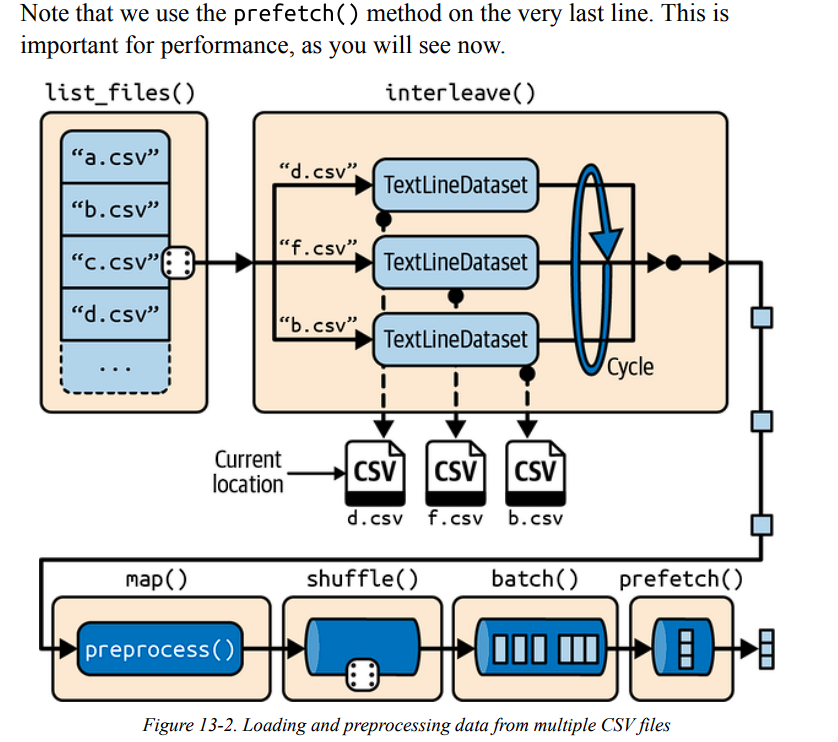

### Prefetching:

1. at the end while our training algorithm is working on
one batch, the dataset will already be working in parallel on getting the next
batch ready.



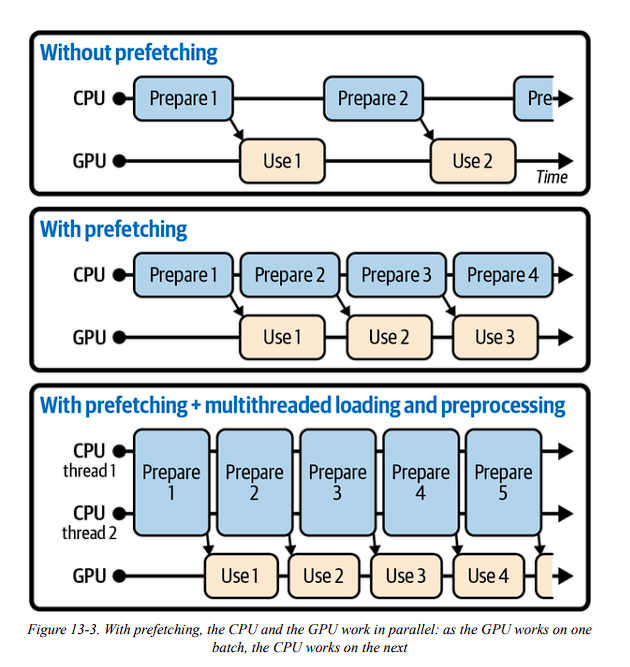

If we also ensure that loading and preprocessing are multithreaded (by
setting num_parallel_calls when calling interleave() and map()), we
can exploit multiple CPU cores and hopefully make preparing one batch of
data shorter than running a training step on the GPU: this way the GPU will
be almost 100% utilized (except for the data transfer time from the CPU to
the GPU ), and training will run much faster.


> TIP
If you plan to purchase a GPU card, its processing power and its memory size are of
course very important (in particular, a large amount of RAM is crucial for large
computer vision or natural language processing models). Just as important for good
performance is the GPU’s memory bandwidth; this is the number of gigabytes of data it
can get into or out of its RAM per second.

* If the dataset is small enough to fit in memory, you can significantly speed
up training by using the dataset’s cache() method to cache its content to
RAM. You should generally do this after loading and preprocessing the
data, but before shuffling, repeating, batching, and prefetching. This way,
each instance will only be read and preprocessed once (instead of once per
epoch), but the data will still be shuffled differently at each epoch, and the
next batch will still be prepared in advance

### Using the dataset with keras

In [25]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

The fit() method will take
care of repeating the training dataset once per epoch, using a different
random order at each epoch:

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5


C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    359/Unknown 2s 2ms/step - loss: 1.5043

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4983 - val_loss: 407.0472
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.5060 - val_loss: 1.5698
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5974 - val_loss: 1.2219
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4735 - val_loss: 1.3016
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4514 - val_loss: 0.4619


In [27]:
"""Similarly, you can pass a dataset to the evaluate() and predict()
methods:
"""
test_mse = model.evaluate(test_set)
new_set = test_set.take(3) # pretend we have 3 new samples
y_pred = model.predict(new_set) # or you could just pass a NumPy array


162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3886
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [28]:
"""If you want to build your own custom training loop (as discussed in
Chapter 12), you can just iterate over the training set, very naturally:"""
# extra code – defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Epoch 5/5

In [ ]:
"""In fact, it is even possible to create a TF function (see Chapter 12) that
trains the model for a whole epoch. This can really speed up training:"""

@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

* In Keras, the steps_per_execution argument of the compile() method
lets you define the number of batches that the fit() method will process
during each call to the tf.function it uses for training.

* The default is just
1, so if you set it to 50 you will often see a significant performance
improvement. However, the on_batch_*() methods of Keras callbacks will
only be called every 50 batches.

> TIP
If you are happy with CSV files (or whatever other format you are using), you do not
have to use TFRecords. As the saying goes, if it ain’t broke, don’t fix it! TFRecords are
useful when the bottleneck during training is loading and parsing the data.

### The TFRecord Format



In [29]:
"""You can easily create a TFRecord file using the tf.io.TFRecordWriter
class:"""

with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [30]:
"""you can then use a tf.data.TFRecordDataset to read one or more
TFRecord files:"""

filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


>TIP
By default, a TFRecordDataset will read files one by one, but you can make it read
multiple files in parallel and interleave their records by passing the constructor a list of
filepaths and setting num_parallel_reads to a number greater than one. Alternatively,
you could obtain the same result by using list_files() and interleave() as we did
earlier to read multiple CSV files.


In [31]:
# extra code – shows how to read multiple files in parallel and interleave them

filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


### Compressed TFRecord Files

In [32]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord",options) as f:
    f.write(b"Compress, compress, compress!")

In [33]:
# reading from compressed TFR file
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")


### Protocol Buffer

1. TFRecord
files usually contain serialized protocol buffers (also called protobufs). This
is a portable, extensible, and efficient binary format.

In [ ]:
"""
content in message.proto 

%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

"""

* This protobuf definition says we are using version 3 of the protobuf format,
and it specifies that each Person object may (optionally) have a name of
type string, an id of type int32, and zero or more email fields, each of type
string. The numbers 1, 2, and 3 are the field identifiers: they will be used in
each record’s binary representation. Once you have a definition in a .proto
file, you can compile it. This requires protoc, the protobuf compiler, to
generate access classes in Python (or some other language).

* Note that the
protobuf definitions you will generally use in TensorFlow have already
been compiled for you, and their Python classes are part of the TensorFlow
library, so you will not need to use protoc. All you need to know is how to
use protobuf access classes in Python.

In [39]:
!protoc message.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [42]:
%ls person*

 Volume in drive C is Acer
 Volume Serial Number is 6042-7170

 Directory of c:\Users\haide\OneDrive\Desktop\projects files\python programs\ML\Deep Learning\CH-13-Loading and Preprocessing Data with TF

09-02-2025  12:50                93 person.desc
               1 File(s)             93 bytes
               0 Dir(s)  248,979,091,456 bytes free


In [44]:
"""example that uses the access classes generated for the Person
protobuf (the code is explained in the comments):"""

from message_pb2 import Person
person = Person(name="Al",id=123,email=["a@b.com"])
print(person)

name: "Al"
id: 123
email: "a@b.com"



In [45]:
person.name = "Alice" # modify a field

In [46]:
person.name

'Alice'

In [47]:
person.email[0] # repeated fields can be accessed like arrays

'a@b.com'

In [48]:
person.email.append("c@d.com") # add an email address

In [50]:
serialized = person.SerializeToString() # serialize person to a byte

In [51]:
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [52]:
person2 = Person() # create a new Person (object)

In [53]:
person2.ParseFromString(serialized) #parse teh byte string (27 bytes long)

27

In [54]:
person == person2 # now they are equal

True

* You could save the serialized Person object to a TFRecord file, then load
and parse it: everything would work fine. However, ParseFromString() is
not a TensorFlow operation, so you couldn’t use it in a preprocessing
function in a tf.data pipeline (except by wrapping it in a
tf.py_function() operation, which would make the code slower and less
portable).

* However, you could use the
tf.io.decode_proto() function, which can parse any protobuf you want,
provided you give it the protobuf definition

In [55]:
# custom protobuf

# extra code – shows how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

### TF Protobufs

* Example
protobuf, which represents one instance in a dataset. It contains a list of
named features, where each feature can either be a list of byte strings, a list
of floats, or a list of integers.


In [ ]:
"""
definition of the tf.train.Example protobuf:

syntax = "proto3"
message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int 64 value = 1 [packed = true]; }
message Feature {
    oneof kind{
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature > feature = 1; }
message Example { Features features = 1; };"""

* Note that [packed = true] is used for repeated
numerical fields, for a more efficient encoding.

*  A Feature contains either a
BytesList, a FloatList, or an Int64List. A Features (with an s)
contains a dictionary that maps a feature name to the corresponding feature
value.

* an Example contains only a Features object.

In [56]:
"""create a tf.train.Example representing the same
person as earlier:"""
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature,Features,Example

person_example = Example(
    features = Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }
    )
)

In [57]:
"""Now that we have an Example protobuf, we can
serialize it by calling its SerializeToString() method, then write the
resulting data to a TFRecord file."""

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(3):
        f.write(person_example.SerializeToString())

* In practise you will be creating an Example protobuf for each instance, serializes them,
and saves them to several TFRecord files, ideally shuffling them in the
process. This requires a bit of work, so once again make sure it is really
necessary (perhaps your pipeline works fine with CSV files).

### Loading and Parsing Exmaple

* tf.io.parse_single_example()  requires at least two arguments:
a string scalar tensor containing the serialized data, and a description of
each feature.

*  tf.io.FixedLenFeature descriptor indicating the feature’s shape,
type, and default value.

* tf.io.VarLenFeature descriptor indicating
only the type if the length of the feature’s list may vary

In [58]:
feature_description = {
    "name": tf.io.FixedLenFeature([],tf.string,default_value=""),
    "id": tf.io.FixedLenFeature([],tf.int64,default_value=0),
    "emails":tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example,feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}


In [59]:
"""The fixed-length features are parsed as regular tensors, but the variablelength features are parsed as sparse tensors. You can convert a sparse tensor
to a dense tensor using tf.sparse.to_dense(), but in this case it is
simpler to just access its values:
"""

tf.sparse.to_dense(parsed_example["emails"],default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [60]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [61]:
"""Instead of parsing examples one by one using
tf.io.parse_single_example(), you may want to parse them batch by
batch using tf.io.parse_example():
"""

def parse(serialized_example):
    return tf.io.parse_example(serialized_example,feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples) # 2 examples at a time

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}


*  For example, you can use tf.io.encode_jpeg() to
encode an image using the JPEG format and put this binary data in a
BytesList.

* Later, when your code reads the TFRecord, it will start by
parsing the Example, then it will need to call tf.io.decode_jpeg() to
parse the data and get the original image (or you can use
tf.io.decode_image(), which can decode any BMP, GIF, JPEG, or PNG
image).



*  You can also store any tensor you want in a BytesList by
serializing the tensor using tf.io.serialize_tensor() then putting the
resulting byte string in a BytesList feature. Later, when you parse the
TFRecord, you can parse this data using tf.io.parse_tensor().

### Handling Lists of Lists Using the SequenceExample Protobuf

* Each document may be represented as a list of
sentences, where each sentence is represented as a list of words. And
perhaps each document also has a list of comments, where each comment is
represented as a list of words. There may be some contextual data too, such
as the document’s author, title, and publication date. TensorFlow’s
SequenceExample protobuf is designed for such use cases.




# sequence example



In [ ]:
"""

message FeatureList { repeated Feature feature = 1; };<br>
message FeatureLists { map<string, FeatureList> feature_list = 1; };<br>
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};

"""

* A SequenceExample contains a Features object for the contextual data
and a FeatureLists object that contains one or more named FeatureList
objects (e.g., a FeatureList named "content" and another named
"comments").

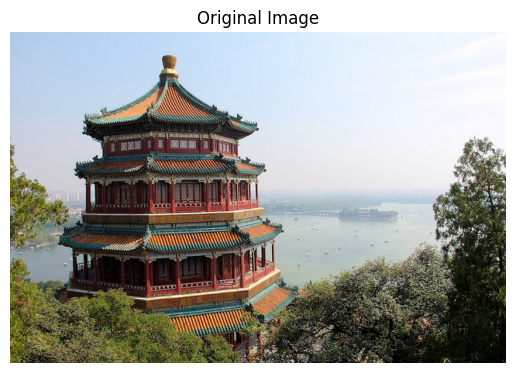

In [63]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

Now let's create an Example protobuf containing the image encoded as JPEG:

In [64]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

Finally, let's create a tf.data pipeline that will read this TFRecord file, parse each Example protobuf (in this case just one), and parse and display the image that the example contains:

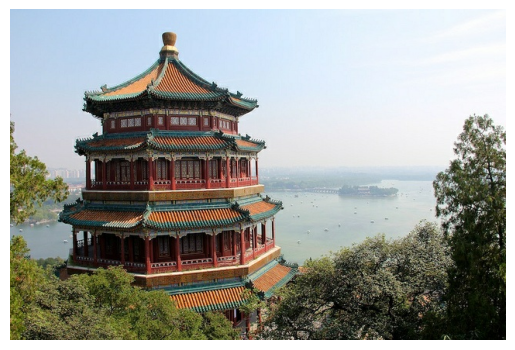

In [65]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Or use decode_image() which supports BMP, GIF, JPEG and PNG formats:

Tensors can be serialized and parsed easily using tf.io.serialize_tensor() and tf.io.parse_tensor():

In [66]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [67]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [68]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [69]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

Handling Lists of Lists Using the SequenceExample Protobuf:


In [ ]:
"""
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
"""

In [70]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [71]:
sequence_example

context {
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "content"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "shall"
          value: "we"
          value: "three"
          value: "meet"
          value: "again"
          value: "?"
        }
      }
      feature {
        bytes_list {
          value: "In"
          value: "thunder"
          value: ","
          value: "lightning"
          value: ","
          value: "or"
          value: "in"
          value: "rain"
          value: "?"
        }
      }
    }
  }
  feature_list {
    key: "c

In [72]:
serialized_sequence_example = sequence_example.SerializeToString()

In [73]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [ ]:
parsed_contextparsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [75]:
parsed_context

{'title': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]
  [3]], shape=(4, 1), dtype=int64), values=tf.Tensor([b'A' b'desert' b'place' b'.'], shape=(4,), dtype=string), dense_shape=tf.Tensor([4], shape=(1,), dtype=int64)),
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [76]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [77]:
parsed_feature_lists

{'comments': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]], shape=(14, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'the' b'hurlyburly' b"'s" b'done' b'.' b'When' b'the' b'battle'
  b"'s" b'lost' b'and' b'won' b'.'], shape=(14,), dtype=string), dense_shape=tf.Tensor([2 8], shape=(2,), dtype=int64)),
 'content': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]
  [0 2]
  [0 3]
  [0 4]
  [0 5]
  [0 6]
  [1 0]
  [1 1]
  [1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]
  [1 7]
  [1 8]], shape=(16, 2), dtype=int64), values=tf.Tensor(
 [b'When' b'shall' b'we' b'three' b'meet' b'again' b'?' b'In' b'thunder'
  b',' b'lightning' b',' b'or' b'in' b'rain' b'?'], shape=(16,), dtype=string), dense_shape=tf.Tensor([2 9], shape=(2,), dtype=int64))}

In [78]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


### Keras Preprocessing Layers

#### several options

* The preprocessing can be done ahead of time when preparing your
training data files, using any tools you like, such as NumPy, Pandas, or
Scikit-Learn. You will need to apply the exact same preprocessing
steps in production, to ensure your production model receives
preprocessed inputs similar to the ones it was trained on.

* Alternatively, you can preprocess your data on the fly while loading it
with tf.data, by applying a preprocessing function to every element of
a dataset using that dataset’s map() method, as we did earlier in this
chapter. Again, you will need to apply the same preprocessing steps in
production.

* One last approach is to include preprocessing layers directly inside
your model so it can preprocess all the input data on the fly during
training, then use the same preprocessing layers in production. 

### The Normalization Layer

1.  Keras provides a Normalization layer that we
can use to standardize the input features. We can either specify the mean
and variance of each feature when creating the layer or—more simply—
pass the training set to the layer’s adapt() method before fitting the model,
so the layer can measure the feature means and variances on its own before
training:


In [79]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train) # computes the mean and variance of every feature
model.fit(X_train,y_train,validation_data=(X_valid,y_valid),
          epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.7535 - val_loss: 1.2838
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9851 - val_loss: 1.1288
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7458 - val_loss: 1.0799
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6847 - val_loss: 0.6340
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6736 - val_loss: 1.8541


> TIP
The data sample passed to the adapt() method must be large enough to be
representative of your dataset, but it does not have to be the full training set: for the
Normalization layer, a few hundred instances randomly sampled from the training set
will generally be sufficient to get a good estimate of the feature means and variances.

2. Since we included the Normalization layer inside the model, we can now
deploy this model to production without having to worry about
normalization again: the model will just handle it.

3. This approach completely eliminates the risk of preprocessing
mismatch, which happens when people try to maintain different
preprocessing code for training and production but update one and forget to
update the other. The production model then ends up receiving data
preprocessed in a way it doesn’t expect. If they’re lucky, they get a clear
bug. If not, the model’s accuracy just silently degrades.

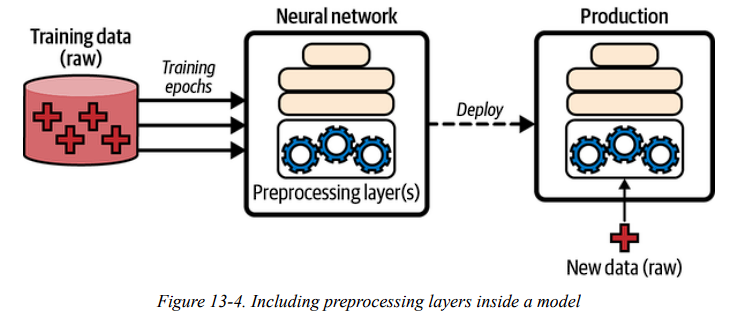

4. We can do better by
normalizing the whole training set just once before training. To do this, we
can use the Normalization layer in a standalone fashion

In [80]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [81]:
# Now we can train a model on the scaled data, this time without a
# Normalization layer

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled,y_train,epochs=5,
          validation_data=(X_valid_scaled,y_valid))

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.1803 - val_loss: 1.4850
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7967 - val_loss: 1.0093
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5922 - val_loss: 0.5526
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5729 - val_loss: 0.5286
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5485 - val_loss: 1.1483


5. But now the model won’t
preprocess its inputs when we deploy it to production. To fix this, we just
need to create a new model that wraps both the adapted Normalization
layer and the model we just trained.

In [82]:
final_model = tf.keras.Sequential([norm_layer,model])
X_new = X_test[:3] # unscaled new instances (let)
y_pred = final_model(X_new)

In [83]:
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.8197751],
       [1.7205284],
       [2.4642532]], dtype=float32)>

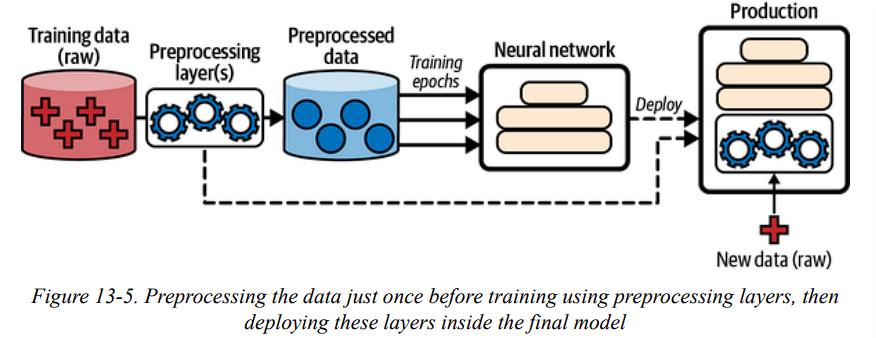


6. Now we have the best of both worlds: training is fast because we only
preprocess the data once before training begins, and the final model can
preprocess its inputs on the fly without any risk of preprocessing mismatch.


7. the Keras preprocessing layers play nicely with the tf.data API.


In [84]:
# extra code – creates a dataset to demo applying the norm_layer using map()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)

In [85]:
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

In [86]:
list(dataset.take(1))  # extra code – shows the first batch

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397889, -1.0778131 , -0.9433854 ,  0.01485314,  0.02073333,
          -0.57291627,  0.9292612 , -1.4221537 ],
         [ 0.7519831 , -1.868895  ,  0.40547806, -0.23327684,  1.8614649 ,
           0.20516537, -0.9165477 ,  1.0966716 ],
         [-0.41469118,  0.02970133,  0.8180882 ,  1.0567837 , -0.0878671 ,
          -0.2998328 ,  1.3087282 , -1.697027  ],
         [ 1.7188957 , -1.3151377 ,  0.32664376, -0.2195511 , -0.33792186,
          -0.11146631, -0.9821345 ,  0.94174504],
         [-0.9620722 , -1.2360295 , -0.05625783, -0.03124396,  1.7090592 ,
          -0.30256987, -0.80411196,  1.3265638 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [87]:
"""if the Normalization layer didn’t exist, you
could get a similar result using the following custom layer:
"""

import numpy as np
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self,X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self,inputs):
        eps = tf.keras.backend.epsilon() # a small smoothing term
        return (inputs - self.mean_) / (self.std_ + eps)

In [88]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

### The Discretization Layer:

1. The Discretization layer’s goal is to transform a numerical feature into a
categorical feature by mapping value ranges (called bins) to categories. 

2. This
is sometimes useful for features with multimodal distributions, or with
features that have a highly non-linear relationship with the target.


In [94]:
"""the following code maps a numerical age feature to three
categories, less than 18, 18 to 50 (not included), and 50 or over:"""

age = tf.constant([[10.],[93.],[57.],[18.],[37.],[5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18.,50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

3. provide the number of bins you want, then call the layer’s
adapt() method to let it find the appropriate bin boundaries based on the
value percentiles

In [95]:
"""For example, if we set num_bins=3, then the bin
boundaries will be located at the values just below the 33rd and 66th
percentiles (in this example, at the values 10 and 37):
"""

discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

> NOTE: Category identifiers such as these should generally not be passed directly to
a neural network, as their values cannot be meaningfully compared. Instead,
they should be encoded, for example using one-hot encoding

### CategoryEncoding layer


In [96]:
#   let’s onehot encode the age_categories feature we just created:
oh_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
oh_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

1. If you try to encode more than one categorical feature at a time (which only
makes sense if they all use the same categories), the CategoryEncoding
class will perform multi-hot encoding by default: the output tensor will
contain a 1 for each category present in any input feature.

In [97]:
two_age_categories = np.array([[1,0],[2,2],[2,0]])
oh_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

2. If you believe it’s useful to know how many times each category occurred,
you can set output_mode="count" when creating the CategoryEncoding
layer, in which case the output tensor will contain the number of
occurrences of each category.

3. Note that both multi-hot encoding and count encoding lose information,
since it’s not possible to know which feature each active category came
from.

In [99]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

 For example, both [0, 1] and [1, 0] are encoded as [1., 1.,
0.]. If you want to avoid this, then you need to one-hot encode each feature
separately and concatenate the outputs. This way, [0, 1] would get
encoded as [1., 0., 0., 0., 1., 0.] and [1, 0] would get encoded as
[0., 1., 0., 1., 0., 0.]. You can get the same result by tweaking the
category identifiers so they don’t overlap

In [98]:
oh_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
oh_layer(two_age_categories + [0,3]) # adds 3 to the second feature


<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [100]:
# extra code – shows another way to one-hot encode each feature separately
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3,
                                                output_mode="one_hot")
tf.keras.layers.concatenate([onehot_layer(cat)
                             for cat in tf.transpose(two_age_categories)])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [101]:
# extra code – shows another way to do this, using tf.one_hot() and Flatten
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

### StringLookup Layer

In [102]:
#  Let’s use the Keras StringLookup layer to one-hot encode a cities
# feature:

cities =  ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"],["Auckland"],["Auckland"],["Montreal"]])



<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

We first create a StringLookup layer, then we adapt it to the data: it finds
that there are three distinct categories. Then we use the layer to encode a
few cities. They are encoded as integers by default. Unknown categories get
mapped to 0, as is the case for “Montreal” in this example. The known
categories are numbered starting at 1, from the most frequent category to
the least frequent.


1. if you set output_mode="one_hot" when creating the
StringLookup layer, it will output a one-hot vector for each category,
instead of an integer:

In [103]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"],["Auckland"],["Auckland"],["Montreal"]])


<tf.Tensor: shape=(4, 4), dtype=int64, numpy=
array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]], dtype=int64)>

2. If the training set is very large, it may be convenient to adapt the layer to
just a random subset of the training set. In this case, the layer’s adapt()
method may miss some of the rarer categories.

3. By default, it would then
map them all to category 0, making them indistinguishable by the model. To
reduce this risk (while still adapting the layer only on a subset of the
training set), you can set num_oov_indices to an integer greater than 1.

4. This is the number of out-of-vocabulary (OOV) buckets to use: each
unknown category will get mapped pseudorandomly to one of the OOV
buckets, using a hash function modulo the number of OOV buckets. This
will allow the model to distinguish at least some of the rare categories.

In [104]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])


<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

5. Since there are five OOV buckets, the first known category’s ID is now 5
("Paris"). But "Foo", "Bar", and "Baz" are unknown, so they each get
mapped to one of the OOV buckets. "Bar" gets its own dedicated bucket
(with ID 3), but sadly "Foo" and "Baz" happen to be mapped to the same
bucket (with ID 4), so they remain indistinguishable by the model. This is
called a hashing collision. 

6.  The only way to reduce the risk of collision is to
increase the number of OOV buckets. However, this will also increase the
total number of categories, which will require more RAM and extra model
parameters once the categories are one-hot encoded. So, don’t increase that
number too much.


In [106]:
# extra code – an example using the IntegerLookup layer
ids = [123, 456, 789]
int_lookup_layer = tf.keras.layers.IntegerLookup()
int_lookup_layer.adapt(ids)
int_lookup_layer([[123], [456], [123], [111]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[3],
       [2],
       [3],
       [0]], dtype=int64)>

### Hashing Layer

1. For each category, the Keras Hashing layer computes a hash, modulo the
number of buckets (or “bins”). The mapping is entirely pseudorandom, but
stable across runs and platforms (i.e., the same category will always be
mapped to the same integer, as long as the number of bins is unchanged).



In [107]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"],["Tokyo"],["Auckland"],["Montreal"]])


<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

2. The benefit of this layer is that it does not need to be adapted at all, which
may sometimes be useful, especially in an out-of-core setting (when the
dataset is too large to fit in memory).

3. However, we once again get a hashing
collision: “Tokyo” and “Montreal” are mapped to the same ID, making
them indistinguishable by the model. So, it’s usually preferable to stick to
the StringLookup layer.


### Encoding Categorical Features Using Embeddings

1. An embedding is a dense representation of some higher-dimensional data,
such as a category, or a word in a vocabulary. If there are 50,000 possible
categories, then one-hot encoding would produce a 50,000-dimensional
sparse vector (i.e., containing mostly zeros). In contrast, an embedding
would be a comparatively small dense vector; for example, with just 100
dimensions.

2. In deep learning, embeddings are usually initialized randomly, and they are
then trained by gradient descent, along with the other model parameters.
For example, the "NEAR BAY" category in the California housing dataset
could be represented initially by a random vector such as [0.131, 0.890],
while the "NEAR OCEAN" category might be represented by another random
vector such as [0.631, 0.791].In this example, we use 2D embeddings,
but the number of dimensions is a hyperparameter you can tweak.

3. Since these embeddings are trainable, they will gradually improve during
training; and as they represent fairly similar categories in this case, gradient
descent will certainly end up pushing them closer together, while it will
tend to move them away from the "INLAND" category’s embedding (see
Figure 13-6).

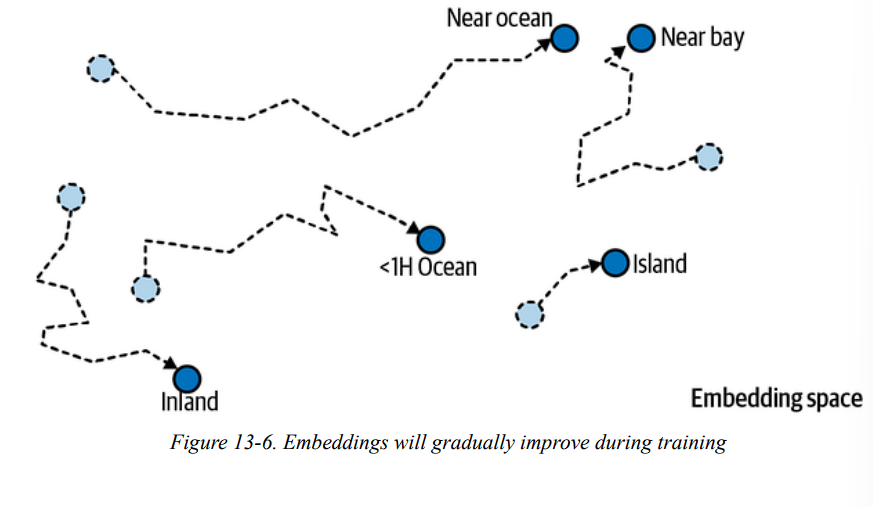

4. the better the representation, the easier it will be for
the neural network to make accurate predictions, so training tends to make
embeddings useful representations of the categories. This is called
representation learning.




In [108]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.0239995 , -0.02495527],
       [-0.01732621, -0.02666501],
       [ 0.0239995 , -0.02495527]], dtype=float32)>

### Word Embeddings

> Not only will embeddings generally be useful representations for the
task at hand, but quite often these same embeddings can be reused
successfully for other tasks. The most common example of this is word
embeddings (i.e., embeddings of individual words): when you are
working on a natural language processing task, you are often better off
reusing pretrained word embeddings than training your own.

> The idea of using vectors to represent words dates back to the 1960s,
and many sophisticated techniques have been used to generate useful
vectors, including using neural networks. But things really took off in
2013, when Tomáš Mikolov and other Google researchers published a
paper describing an efficient technique to learn word embeddings
using neural networks, significantly outperforming previous attempts.
This allowed them to learn embeddings on a very large corpus of text:
they trained a neural network to predict the words near any given word
and obtained astounding word embeddings. For example, synonyms
had very close embeddings, and semantically related words such as
France, Spain, and Italy ended up clustered together.

> It’s not just about proximity, though: word embeddings were also
organized along meaningful axes in the embedding space. Here is a
famous example: if you compute King – Man + Woman (adding and
subtracting the embedding vectors of these words), then the result will
be very close to the embedding of the word Queen (see Figure 13-7). In
other words, the word embeddings encode the concept of gender!
Similarly, you can compute Madrid – Spain + France, and the result is
close to Paris, which seems to show that the notion of capital city was
also encoded in the embeddings.

> Unfortunately, word embeddings sometimes capture our worst biases.
For example, although they correctly learn that Man is to King as
Woman is to Queen, they also seem to learn that Man is to Doctor as
Woman is to Nurse: quite a sexist bias! To be fair, this particular
example is probably exaggerated, as was pointed out in a 2019 paper
by Malvina Nissim et al. Nevertheless, ensuring fairness in deep
learning algorithms is an important and active research topic.


5. Keras provides an Embedding layer, which wraps an embedding matrix: this
matrix has one row per category and one column per embedding dimension.
By default, it is initialized randomly.

6. To convert a category ID to an
embedding, the Embedding layer just looks up and returns the row that
corresponds to that category

In [ ]:
"""let’s
initialize an Embedding layer with five rows and 2D embeddings, and use it
to encode some categories:"""
# As you can see, category 2 gets encoded (twice) as the 2D vector

tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2,4,2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.02664487, -0.02268622],
       [-0.00533539,  0.0141183 ],
       [ 0.02664487, -0.02268622]], dtype=float32)>

>WARNING
An Embedding layer is initialized randomly, so it does not make sense to use it outside
of a model as a standalone preprocessing layer unless you initialize it with pretrained
weights.



In [112]:
"""If you want to embed a categorical text attribute, you can simply chain a
StringLookup layer and an Embedding layer,"""

tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.03858754, 0.03638574],
       [0.02058274, 0.01716265],
       [0.03858754, 0.03638574]], dtype=float32)>

7. Note that the number of rows in the embedding matrix needs to be equal to
the vocabulary size: that’s the total number of categories, including the
known categories plus the OOV buckets (just one by default). The
vocabulary_size() method of the StringLookup class conveniently
returns this number.


> TIP
In this example we used 2D embeddings, but as a rule of thumb embeddings typically
have 10 to 300 dimensions, depending on the task, the vocabulary size, and the size of
your training set. You will have to tune this hyperparameter.

8. Putting everything together, we can now create a Keras model that can
process a categorical text feature along with regular numerical features and
learn an embedding for each category (as well as for each OOV bucket):


In [113]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000).astype(object)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000).astype(object)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input) 
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2035 - val_loss: 0.1329
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1219 - val_loss: 0.1018
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0969 - val_loss: 0.0905
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0879 - val_loss: 0.0862
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0845 - val_loss: 0.0845


In [114]:
# extra code – shows that the model can also be trained using a tf.data.Dataset
train_set = tf.data.Dataset.from_tensor_slices(
    ((X_train_num, X_train_cat), y_train)).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(
    ((X_valid_num, X_valid_cat), y_valid)).batch(32)
history = model.fit(train_set, epochs=5,
                    validation_data=valid_set)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0839 - val_loss: 0.0839
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0834 - val_loss: 0.0835
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0831 - val_loss: 0.0833
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0829 - val_loss: 0.0832
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0828 - val_loss: 0.0831


> NOTE
One-hot encoding followed by a Dense layer (with no activation function and no biases)
is equivalent to an Embedding layer. However, the Embedding layer uses way fewer
computations as it avoids many multiplications by zero—the performance difference
becomes clear when the size of the embedding matrix grows. The Dense layer’s weight
matrix plays the role of the embedding matrix. For example, using one-hot vectors of
size 20 and a Dense layer with 10 units is equivalent to using an Embedding layer with
input_dim=20 and output_dim=10. As a result, it would be wasteful to use more
embedding dimensions than the number of units in the layer that follows the Embedding
layer.

### Text Preprocessing

1. Keras provides a TextVectorization layer for basic text preprocessing. you must either pass it a vocabulary
upon creation, or let it learn the vocabulary from some training data using
the adapt() method.



In [115]:
"""The two sentences “Be good!” and “Question: be or be?” were encoded as
[2, 1, 0, 0] and [6, 2, 1, 2], respectively. The vocabulary was
learned from the four sentences in the training data: “be” = 2, “to” = 3, etc"""

train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec__layer = tf.keras.layers.TextVectorization()
text_vec__layer.adapt(train_data)
text_vec__layer(["Be good!","Question: be or be?"])


<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

2. To construct the vocabulary, the adapt() method first converted the
training sentences to lowercase and removed punctuation, which is why
“Be”, “be”, and “be?” are all encoded as “be” = 2. Next, the sentences were
split on whitespace, and the resulting words were sorted by descending
frequency, producing the final vocabulary. When encoding sentences,
unknown words get encoded as 1s. Lastly, since the first sentence is shorter
than the second, it was padded with 0s.


> TIP: 
The TextVectorization layer has many options. For example, you can preserve the
case and punctuation if you want, by setting standardize=None, or you can pass any
standardization function you please as the standardize argument. You can prevent
splitting by setting split=None, or you can pass your own splitting function instead.
You can set the output_sequence_length argument to ensure that the output
sequences all get cropped or padded to the desired length, or you can set ragged=True
to get a ragged tensor instead of a regular tensor. Please check out the documentation for
more options.


In [117]:
text_vec_layer = tf.keras.layers.TextVectorization(ragged=True)
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.RaggedTensor [[2, 1], [6, 2, 1, 2]]>

3.  simply counting
words is usually not ideal: words like “to” and “the” are so frequent that
they hardly matter at all, whereas, rarer words such as “basketball” are
much more informative. So, rather than setting output_mode to
"multi_hot" or "count", it is usually preferable to set it to "tf_idf",
which stands for term-frequency × inverse-document-frequency (TF-IDF).

In [116]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!","Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

In [118]:
2 * np.log(1 + 4 / (1 + 3))

1.3862943611198906

In [119]:
1 * np.log(1 + 4 / (1 + 1))

1.0986122886681098

4. There are many TF-IDF variants, but the way the TextVectorization
layer implements it is by multiplying each word count by a weight equal to
log(1 + d / (f + 1)), where d is the total number of sentences (a.k.a.,
documents) in the training data and f counts how many of these training
sentences contain the given word.

>Note that the average
weight is used for unknown words.

5. it only works with languages that separate
words with spaces, it doesn’t distinguish between homonyms (e.g., “to
bear” versus “teddy bear”), it gives no hint to your model that words like
“evolution” and “evolutionary” are related, etc. And if you use multi-hot,
count, or TF-IDF encoding, then the order of the words is lost. So what are
the other options?

* One option is to use the TensorFlow Text library, which provides more
advanced text preprocessing features than the TextVectorization layer.
For example, it includes several subword tokenizers capable of splitting the
text into tokens smaller than words, which makes it possible for the model
to more easily detect that “evolution” and “evolutionary” have something in
common (more on subword tokenization in Chapter 16).


* Yet another option is to use pretrained language model components.



### Using Pretrained Language Model Components:

1. The [ TensorFlow Hub library](https://tensorflow.org/hub) makes it easy to reuse pretrained model
components in your own models, for text, image, audio, and more. These
model components are called modules. 

2.  Simply browse the [TF Hub repo](https://tfhub.dev/) Hub
repository, find the one you need, and copy the code example into your
project, and the module will be automatically downloaded and bundled into
a Keras layer that you can directly include in your model.

3.  Modules typically
contain both preprocessing code and pretrained weights, and they generally
require no extra training (but of course, the rest of your model will certainly
require training).



In [120]:
"""For example, some powerful pretrained language models are available. The
most powerful are quite large (several gigabytes), so for a quick example
let’s use the nnlm-en-dim50 module, version 2, which is a fairly basic
module that takes raw text as input and outputs 50-dimensional sentence
embeddings. """

"""This model Internally, it parses the string (splitting words on spaces) and embeds each
word using an embedding matrix that was pretrained on a huge corpus: the
8
Google News 7B corpus (seven billion words long!). Then it computes the
mean of all the word embeddings, and the result is the sentence
embedding"""

import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be","Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

4. You just need to include this hub_layer in your model, and you’re ready to
go. Note that this particular language model was trained on the English
language, but many other languages are available, as well as multilingual
models.

5. Last but not least, the excellent open source  [Transformers library by
Hugging Face](https://huggingface.co/docs/transformers) also makes it easy to include powerful language model
components inside your own models. You can browse the  [Hugging Face
Hub ](https://huggingface.co/models), choose the model you want, and use the provided code examples to
get started. It used to contain only language models, but it has now
expanded to include image models and more.



### Image Preprocessing Layers:

#### The Keras preprocessing API includes three image preprocessing layers:

1. tf.keras.layers.Resizing resizes the input images to the desired
size. For example, Resizing(height=100, width=200) resizes each
image to 100 × 200, possibly distorting the image. If you set
crop_to_aspect_ratio=True, then the image will be cropped to the
target image ratio, to avoid distortion.

2. tf.keras.layers.Rescaling rescales the pixel values. For example,
Rescaling(scale=2/255, offset=-1) scales the values from 0 →
255 to –1 → 1.

3. tf.keras.layers.CenterCrop crops the image, keeping only a
center patch of the desired height and width.




In [122]:
"""For example, let’s load a couple of sample images and center-crop them.
For this, we will use Scikit-Learn’s load_sample_images() function; this
loads two color images, one of a Chinese temple and the other of a flower
"""

from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

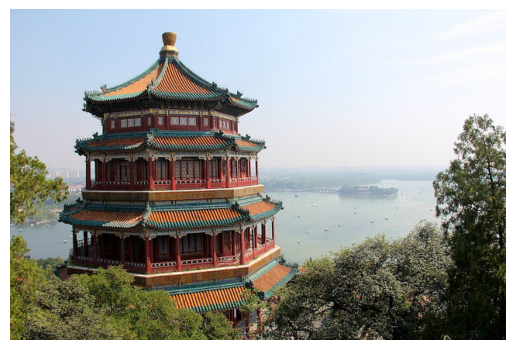

In [123]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

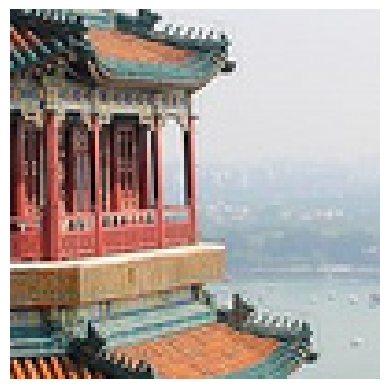

In [124]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

4. Keras also includes several layers for data augmentation, such as
RandomCrop, RandomFlip, RandomTranslation, RandomRotation,
RandomZoom, RandomHeight, RandomWidth, and RandomContrast. These
layers are only active during training, and they randomly apply some
transformation to the input images (their names are self-explanatory).


5. Data
augmentation will artificially increase the size of the training set, which
often leads to improved performance, as long as the transformed images
look like realistic (nonaugmented) images.


### TensorFlow Datasets Project

1. The  [TensorFlow Datasets (TFDS)](https://tensorflow.org/datasets) project makes it very easy to load
common datasets, from small ones like MNIST or Fashion MNIST to huge
datasets like ImageNet (you will need quite a bit of disk space!). The list
includes image datasets, text datasets (including translation datasets), audio
and video datasets, time series, and much more.

2. You can visit
https://homl.info/tfds to view the full list, along with a description of each
dataset. You can also check out  [tKnow Your Data](https://knowyourdata.withgoogle.com/), which is a tool to explore
and understand many of the datasets provided by TFDS.

3. TFDS is not bundled with TensorFlow, but if you are running on Colab or if
you followed the installation instructions at https://homl.info/install, then
it’s already installed. You can then import tensorflow_datasets, usually
as tfds, then call the tfds.load() function, which will download the data
you want (unless it was already downloaded earlier) and return the data as a
dictionary of datasets (typically one for training and one for testing, but this
depends on the dataset you choose).

In [125]:
# MNIST
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]


In [126]:
"""You can then apply any transformation you want (typically shuffling,
batching, and prefetching), and you’re ready to train your model."""

for batch in mnist_train.shuffle(10_000,seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    

>TIP
The load() function can shuffle the files it downloads: just set shuffle_files=True.
However, this may be insufficient, so it’s best to shuffle the training data some more

In [127]:
"""Note that each item in the dataset is a dictionary containing both the
features and the labels. But Keras expects each item to be a tuple containing
two elements (again, the features and the labels). You could transform the
dataset using the map() method,"""

mnist_train = mnist_train.shuffle(buffer_size=10_000,seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"],items["label"]))
mnist_train = mnist_train.prefetch(1)

In [ ]:
"""But it’s simpler to ask the load() function to do this for you by setting
as_supervised=True (obviously this works only for labeled datasets).
"""



In [128]:
"""Lastly, TFDS provides a convenient way to split the data using the split
argument."""

train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)


Epoch 1/5


C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7584 - loss: 18.5428 - val_accuracy: 0.8735 - val_loss: 6.5008
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8784 - loss: 5.8355 - val_accuracy: 0.8743 - val_loss: 5.5584
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8837 - loss: 5.1926 - val_accuracy: 0.8893 - val_loss: 5.5690
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8850 - loss: 5.0975 - val_accuracy: 0.8855 - val_loss: 5.6105
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8911 - loss: 4.7255 - val_accuracy: 0.8738 - val_loss: 6.2027
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8731 - loss: 6.2146


In [129]:
test_loss, test_accuracy = model.evaluate(test_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8731 - loss: 6.2146
